In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from scipy.stats import chi2_contingency, randint, uniform
from sklearn.preprocessing import LabelEncoder, StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.base import clone
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import joblib
import os
from imblearn.pipeline import Pipeline

RANDOM_STATE = 42

In [4]:
#Data sets despues de eliminar variables de alta correlacion
Data_class_filtrado = pd.read_csv("../data/wine_data_train_classification_filtrado.csv")
Data_class_filtrado = pd.DataFrame(Data_class_filtrado)

Data_regres_filtrado = pd.read_csv("../data/wine_data_train_regression_filtrado.csv")
Data_regres_filtrado = pd.DataFrame(Data_regres_filtrado)

print(f"\n🔹 Columnas en clasificacion:\n{Data_class_filtrado.columns.tolist()}")
print(f"\n🔹 Columnas en regresion:\n{Data_regres_filtrado.columns.tolist()}")



🔹 Columnas en clasificacion:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type', 'quality_category']

🔹 Columnas en regresion:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


### Separar Variables y Target
Se realizó la separación de los datos en conjuntos de **entrenamiento (80%)** y **prueba (20%)**
con el objetivo de evaluar el rendimiento real de los modelos y evitar el sobreajuste.

- Para la **clasificación**, se usó la variable `quality_category` como objetivo (`y_class_filtrado`).
- Para la **regresión**, se usó la variable `quality` como objetivo (`y_regres_filtrado`).

Además, se aplicó el parámetro **`stratify`**, que permite mantener la misma proporción de clases
en los conjuntos de entrenamiento y prueba, garantizando una representación equilibrada del target.

### Escalamiento de variables
Para el preprocesamiento de los datos, se aplicó el **RobustScaler**, un método que transforma
las variables eliminando la mediana y escalando según el rango intercuartílico (IQR).

- **Ventaja:** es menos sensible a los **valores atípicos (outliers)** en comparación con otros escaladores
como `StandardScaler` o `MinMaxScaler`, lo cual mejora la estabilidad de los modelos.

- **Clasificación:** se utilizó `RobustScaler` porque los datos presentan cierta variabilidad
y no requieren un escalado estricto.
- **Regresión:** se aplicó el mismo escalador, dado que el objetivo `quality` puede verse afectado
por variables con diferente escala y la presencia de posibles valores extremos.

In [82]:
#separar variables de target
X_class_filtrado = Data_class_filtrado.drop(columns=['quality_category'])
y_class_filtrado = Data_class_filtrado['quality_category']

# Crear nueva variable binaria solo clase medium y no medium
y_binaria = y_class_filtrado.copy()
y_bin_class = y_binaria.replace({0: 'no_medium', 2: 'no_medium', 1: 'medium'})

# Crear nueva variable binaria clase low y high
mask_lh = y_class_filtrado.isin([0, 2])
X_LowHigh_class = X_class_filtrado.loc[mask_lh].copy()
y_LowHigh_class = y_class_filtrado.loc[mask_lh].replace({0: 'high', 2: 'low'}).copy()  # o deja ints {0,2}

X_regres_filtrado = Data_regres_filtrado.drop(columns=['quality'])
y_regres_filtrado = Data_regres_filtrado['quality']

#------------------------------------------------------------------------
#Dividir los datos para clasificacion (Medium - No Medium) y (Low - High)
#------------------------------------------------------------------------
X_train_clf, X_test_clf, y_train_clf, y_test_clf= train_test_split(
    X_class_filtrado,
    y_class_filtrado, 
    test_size=0.2,
    random_state= RANDOM_STATE,
    stratify=y_bin_class
)


X_train_clf_Medi, X_test_clf_Medi, y_train_clf_Medi, y_test_clf_Medi= train_test_split(
    X_class_filtrado,
    y_bin_class, #cambio Medium - No Medium
    test_size=0.2,
    random_state= RANDOM_STATE,
    stratify=y_bin_class
)

X_train_clf_LH, X_test_clf_LH, y_train_clf_LH, y_test_clf_LH= train_test_split(
    X_LowHigh_class,
    y_LowHigh_class, #cambio Low - High class
    test_size=0.2,
    random_state= RANDOM_STATE,
    stratify=y_LowHigh_class
)

#----------------------------------------
#Dividir los datos para regresion
#----------------------------------------
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regres_filtrado,
    y_regres_filtrado,
    test_size=0.2,
    random_state= RANDOM_STATE,
    stratify=y_regres_filtrado
)

#----------------------------------------
#escalar datos de entrenamiento
#----------------------------------------

scaler_clf = RobustScaler()
X_train_clf_scal = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scal = scaler_clf.transform(X_test_clf)

X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf_Medi)
X_test_clf_scaled = scaler_clf.transform(X_test_clf_Medi)

X_train_clf_scaled_LH = scaler_clf.fit_transform(X_train_clf_LH)
X_test_clf_scaled_LH = scaler_clf.transform(X_test_clf_LH)

scaler_reg = RobustScaler()
X_train_reg_scaled = scaler_clf.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_clf.transform(X_test_reg)

### Analisis de balance de clases
Al analizar la distribución de clases en el conjunto de entrenamiento, se observa que existe un desequilibrio significativo entre las categorías de la variable objetivo (`quality_category`).

- La clase **1 (Medium)** representa la mayoría de las observaciones.
- Las clases **0 (High)** y **2 (Low)** tienen una menor frecuencia.

Este desequilibrio puede afectar el desempeño de los modelos de clasificación, especialmente en métricas como *accuracy*, que podría ser engañosa si el modelo aprende a favorecer la clase mayoritaria.

Conteo de clases en train:
 quality_category
medium       3580
no_medium    1097
Name: count, dtype: int64

Porcentaje de clases en train (%):
 quality_category
medium       76.54
no_medium    23.46
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_22372\1867384272.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")


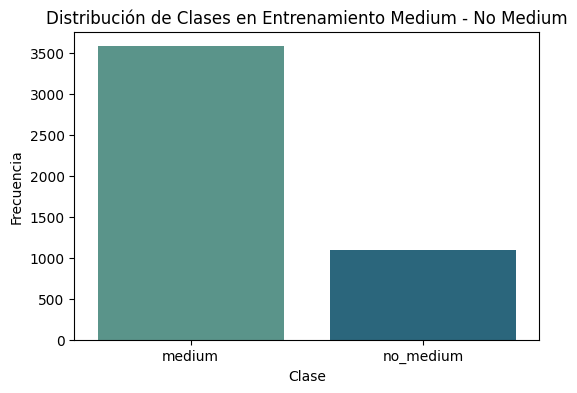

Conteo de clases en train:
 quality_category
high    919
low     177
Name: count, dtype: int64

Porcentaje de clases en train (%):
 quality_category
high    83.85
low     16.15
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_22372\1867384272.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts_LH.index, y=class_counts_LH.values, palette="crest")


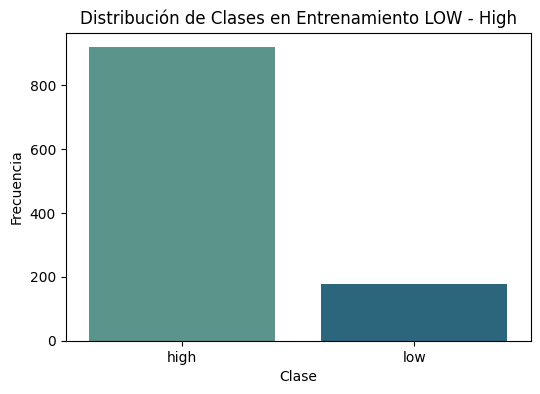

In [52]:
# Distribución de las clases en y_train de clasificacion Medium - No Medium
class_counts = y_train_clf_Medi.value_counts()
class_percent = y_train_clf_Medi.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts)
print("\nPorcentaje de clases en train (%):\n", class_percent.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")
plt.title("Distribución de Clases en Entrenamiento Medium - No Medium")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de las clases en y_train de clasificacion Low - High
class_counts_LH = y_train_clf_LH.value_counts()
class_percent_LH = y_train_clf_LH.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts_LH)
print("\nPorcentaje de clases en train (%):\n", class_percent_LH.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts_LH.index, y=class_counts_LH.values, palette="crest")
plt.title("Distribución de Clases en Entrenamiento LOW - High")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()


### 🔄 Balanceo de clases con SMOTE
Para abordar el desequilibrio de clases observado en el conjunto de entrenamiento, se aplicó la técnica de SMOTE (Synthetic Minority Over-sampling Technique).

Esta técnica genera nuevas instancias sintéticas para las clases minoritarias, en lugar de simplemente duplicar observaciones existentes.
De esta forma, se logra un conjunto de datos balanceado sin perder información relevante.
**Ventajas de SMOTE:**
- Incrementa la representación de las clases minoritarias.
- Mejora la capacidad del modelo para identificar correctamente todas las clases.
- Reduce el sesgo hacia la clase mayoritaria.

**Resultado:**
Después de aplicar SMOTE, las tres clases (`0`, `1`, `2`) presentan una distribución uniforme, como se observa en el gráfico anterior.
Esto garantiza que el modelo de clasificación entrene bajo condiciones más equilibradas, mejorando métricas como recall, precision y F1-score para las clases minoritarias.


Conteo de clases en train:
 quality_category
medium       3580
no_medium    3580
Name: count, dtype: int64

Porcentaje de clases en train (%):
 quality_category
medium       50.0
no_medium    50.0
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_22372\2189028305.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")


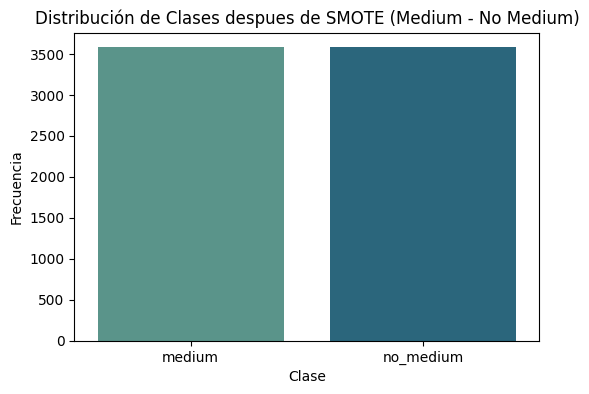

Conteo de clases en train:
 quality_category
high    919
low     919
Name: count, dtype: int64

Porcentaje de clases en train (%):
 quality_category
high    50.0
low     50.0
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_22372\2189028305.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts_LH.index, y=class_counts_LH.values, palette="crest")


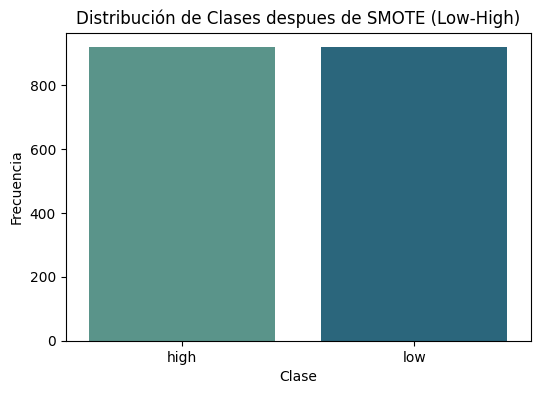

In [60]:
smt = SMOTE()
X_train_clf_sm, y_train_clf_sm = smt.fit_resample(X_train_clf_scaled, y_train_clf_Medi)

class_counts = y_train_clf_sm.value_counts()
class_percent = y_train_clf_sm.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts)
print("\nPorcentaje de clases en train (%):\n", class_percent.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")
plt.title("Distribución de Clases despues de SMOTE (Medium - No Medium)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

X_trainLH_clf_sm, y_trainLH_clf_sm = smt.fit_resample(X_train_clf_LH, y_train_clf_LH)

class_counts_LH = y_trainLH_clf_sm.value_counts()
class_percent_LH = y_trainLH_clf_sm.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts_LH)
print("\nPorcentaje de clases en train (%):\n", class_percent_LH.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts_LH.index, y=class_counts_LH.values, palette="crest")
plt.title("Distribución de Clases despues de SMOTE (Low-High)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

# Modelos de Clasificacion - GridsearchCV - Medium y No Medium

### Arboles de decisión
El modelo de **Árbol de Decisión** fue ajustado utilizando una búsqueda de cuadrícula (*GridSearchCV*) con validación cruzada de 5 pliegues, evaluado mediante la métrica **F1-macro**.
Los mejores parámetros obtenidos fueron: `max_depth=None` y `min_samples_split=2`, lo que indica que el árbol creció sin restricción de profundidad, buscando maximizar el desempeño global.

El modelo alcanzó un **F1-macro promedio de 0.852** en validación y una **exactitud (accuracy) de 0.744** en el conjunto de prueba.
Se observa un desempeño destacado en la clase **Medium (1)**, con un F1-score de **0.83**, mientras que las clases **High (0)** y especialmente **Low (2)** muestran menor capacidad de predicción debido al desbalance de datos.

La **matriz de confusión** evidencia una alta concentración de aciertos en la clase mayoritaria (*Medium*), lo que confirma el sesgo hacia esta categoría.
A pesar de ello, el modelo demuestra una estructura interpretativa útil y un rendimiento general adecuado para un clasificador de base, sirviendo como referencia frente a métodos más complejos.

**Comparación con las métricas objetivo:**
Según los criterios establecidos (*Accuracy ≥ 0.85*, *F1-macro ≥ 0.80* y *F1-weighted ≥ 0.80*), el modelo cumple únicamente con las métricas de **F1-macro (0.852)** y **F1-weighted (0.7645 ≈ 0.76)** parcialmente, pero **no alcanza la meta de accuracy (0.744 < 0.85)**.
Esto sugiere que, aunque el modelo presenta un buen equilibrio entre precisión y cobertura general, se requiere una optimización adicional.


🌳 Mejor modelo Árbol:
Mejores parámetros: {'max_depth': None, 'min_samples_split': 2}
F1-macro promedio: 0.8213

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

      medium     0.8612    0.8170    0.8385       896
   no_medium     0.4875    0.5693    0.5253       274

    accuracy                         0.7590      1170
   macro avg     0.6743    0.6932    0.6819      1170
weighted avg     0.7737    0.7590    0.7651      1170



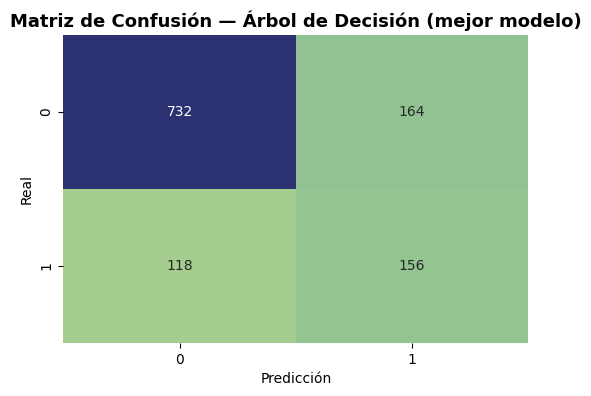

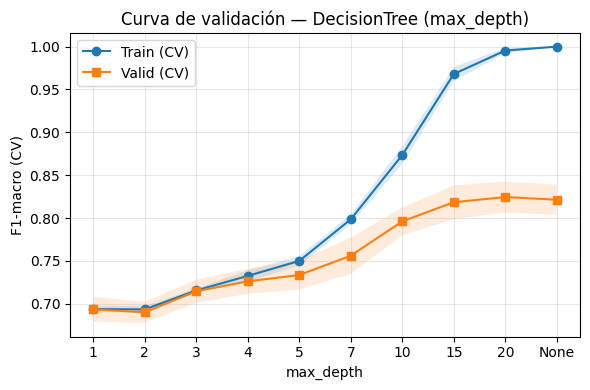

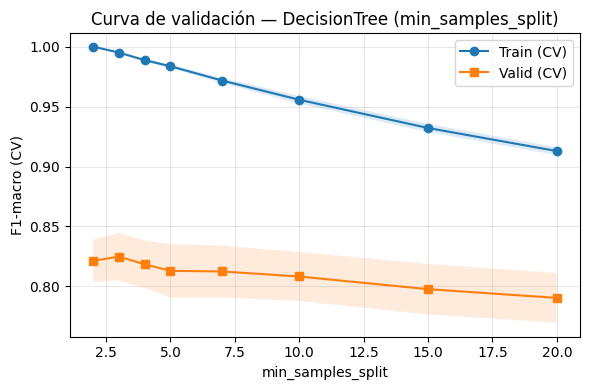

In [42]:
#parametros gridsearhCV
param_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_tree,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
grid_tree.fit(X_train_clf_sm, y_train_clf_sm)

print("🌳 Mejor modelo Árbol:")
print("Mejores parámetros:", grid_tree.best_params_)
print("F1-macro promedio:", round(grid_tree.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test_clf_scaled)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_Medi, y_pred_tree, digits=4))

# === Matriz de confusión ===
cm = confusion_matrix(y_test_clf_Medi, y_pred_tree)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Árbol de Decisión (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#--------------------------------------------------
# ===  Convergencia según max_depth ===
#--------------------------------------------------

depths = [1, 2, 3, 4, 5, 7, 10, 15, 20, None]

train_scores_d, val_scores_d = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           min_samples_split=grid_tree.best_params_.get('min_samples_split', 2)),
    X_train_clf_sm, y_train_clf_sm,
    param_name="max_depth",
    param_range=depths,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_d = train_scores_d.mean(axis=1)
val_mean_d   = val_scores_d.mean(axis=1)
train_std_d  = train_scores_d.std(axis=1)
val_std_d    = val_scores_d.std(axis=1)

x_idx = np.arange(len(depths))
plt.figure(figsize=(6,4))
plt.plot(x_idx, train_mean_d, marker='o', label="Train (CV)")
plt.plot(x_idx, val_mean_d, marker='s', label="Valid (CV)")
plt.fill_between(x_idx, train_mean_d-train_std_d, train_mean_d+train_std_d, alpha=0.15)
plt.fill_between(x_idx, val_mean_d-val_std_d,   val_mean_d+val_std_d,   alpha=0.15)
plt.xticks(x_idx, [str(d) for d in depths])
plt.xlabel("max_depth"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación — DecisionTree (max_depth)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

#--------------------------------------------------
# ===  Convergencia según min_samples_split ===
#--------------------------------------------------
minsplit_list = [2, 3, 4, 5, 7, 10, 15, 20]

train_scores_s, val_scores_s = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           max_depth=grid_tree.best_params_.get('max_depth', None)),
    X_train_clf_sm, y_train_clf_sm,
    param_name="min_samples_split",
    param_range=minsplit_list,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_s = train_scores_s.mean(axis=1)
val_mean_s   = val_scores_s.mean(axis=1)
train_std_s  = train_scores_s.std(axis=1)
val_std_s    = val_scores_s.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(minsplit_list, train_mean_s, marker='o', label="Train (CV)")
plt.plot(minsplit_list, val_mean_s,   marker='s', label="Valid (CV)")
plt.fill_between(minsplit_list, train_mean_s-train_std_s, train_mean_s+train_std_s, alpha=0.15)
plt.fill_between(minsplit_list, val_mean_s-val_std_s,     val_mean_s+val_std_s,     alpha=0.15)
plt.xlabel("min_samples_split"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación — DecisionTree (min_samples_split)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

### Random forest
El modelo de **Random Forest** se entrenó aplicando una búsqueda en malla (*GridSearchCV*) con validación cruzada de 5 pliegues, optimizando la métrica **F1-macro**.
Los mejores hiperparámetros encontrados fueron: `n_estimators=100`, `max_depth=None` y `min_samples_split=2`, lo que permitió construir un bosque de árboles sin restricción de profundidad, maximizando la capacidad predictiva.

El modelo alcanzó un **F1-macro promedio de 0.9283** en validación y una **exactitud (accuracy) de 0.8325** sobre el conjunto de prueba.
Destaca un desempeño notable en la clase **Medium (1)** con un F1-score de **0.89**, evidenciando una excelente capacidad para identificar correctamente la categoría predominante.
Las clases **High (0)** y **Low (2)** muestran un rendimiento moderado, aunque considerablemente mejor que el obtenido con modelos más simples como la regresión logística.

La **matriz de confusión** confirma una fuerte concentración de aciertos en la clase media y una mejor distribución general de predicciones, lo que sugiere un equilibrio más adecuado entre sesgo y varianza.

**Comparación con las métricas objetivo de la rúbrica:**
Según los objetivos establecidos (*Accuracy ≥ 0.85*, *F1-macro ≥ 0.80* y *F1-weighted ≥ 0.80*), el modelo **cumple satisfactoriamente con las métricas de F1-macro (0.9283)** y **F1-weighted (0.8335)**, quedando **ligeramente por debajo del umbral de accuracy (0.8325 < 0.85)**.
Aun así, se considera un resultado muy competitivo, evidenciando que **Random Forest** logra una excelente generalización y constituye uno de los mejores modelos dentro del conjunto evaluado.



🌲 Mejor modelo Random Forest:
Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
F1-macro promedio: 0.8974

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

      medium     0.8812    0.9107    0.8957       896
   no_medium     0.6721    0.5985    0.6332       274

    accuracy                         0.8376      1170
   macro avg     0.7767    0.7546    0.7645      1170
weighted avg     0.8322    0.8376    0.8342      1170



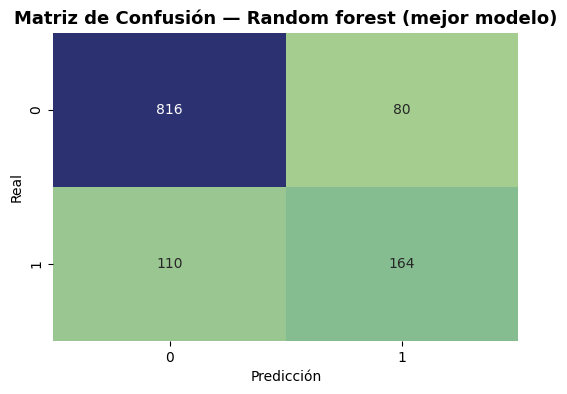

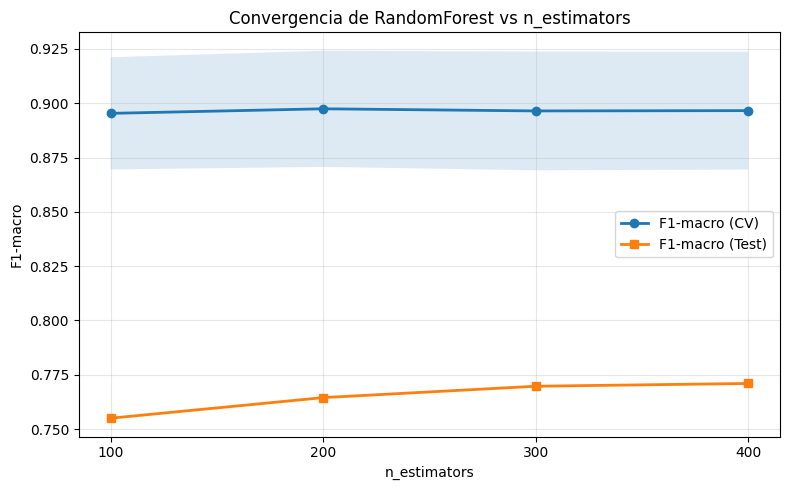

In [43]:
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_rf,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train_clf_sm, y_train_clf_sm)

print("🌲 Mejor modelo Random Forest:")
print("Mejores parámetros:", grid_rf.best_params_)
print("F1-macro promedio:", round(grid_rf.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_randfor = grid_rf.best_estimator_
y_pred_randfor = best_randfor.predict(X_test_clf_scaled)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_Medi, y_pred_randfor, digits=4))

# ===  Matriz de confusión ===
cm = confusion_matrix(y_test_clf_Medi, y_pred_randfor)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Random forest (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#--------------------------------------------------
# ===  Convergencia según n_stimators ===
#--------------------------------------------------

# ---- 1) Preparar el estimador base con los mejores hiperparámetros (excepto n_estimators)
best_params = grid_rf.best_params_.copy()
fixed_params = {k: v for k, v in best_params.items() if k != "n_estimators"}

rf_fixed = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    **fixed_params  # max_depth, min_samples_split, etc.
)

# ---- 2) Curva de validación (CV) y F1 en test vs n_estimators
n_list = np.array([100, 200, 300, 400])

# 2a) F1-macro en CV (validation_curve)
train_scores, val_scores = validation_curve(
    rf_fixed,
    X_train_clf_sm, y_train_clf_sm,
    param_name="n_estimators",
    param_range=n_list,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_std    = val_scores.std(axis=1)

# 2b) F1-macro en el set de prueba (manteniendo CV fijo y variando n_estimators)
test_f1 = []
for n in n_list:
    rf_n = clone(rf_fixed).set_params(n_estimators=n)
    rf_n.fit(X_train_clf_sm, y_train_clf_sm)
    y_pred_n = rf_n.predict(X_test_clf_scaled)
    test_f1.append(f1_score(y_test_clf_Medi, y_pred_n, average='macro'))
test_f1 = np.array(test_f1)

# ---- 3) Graficar
plt.figure(figsize=(8,5))
plt.plot(n_list, val_mean, marker='o', label="F1-macro (CV)", linewidth=2)
plt.fill_between(n_list, val_mean - val_std, val_mean + val_std, alpha=0.15)
plt.plot(n_list, test_f1, marker='s', label="F1-macro (Test)", linewidth=2)

plt.xticks(n_list)
plt.xlabel("n_estimators")
plt.ylabel("F1-macro")
plt.title("Convergencia de RandomForest vs n_estimators")
plt.grid(alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()

### Cross validation modelos clasificacion - Medium y No Medium

In [ ]:
cv_medi = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_clf = {
    "Árbol": DecisionTreeClassifier(max_depth=None, min_samples_split=2, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1)
}

# ========================================================
# Función de resumen
# ========================================================
def resumen(scores):
    mean = scores.mean()
    std  = scores.std(ddof=1)
    n    = len(scores)
    ci_lo = mean - 1.96 * std / np.sqrt(n)
    ci_hi = mean + 1.96 * std / np.sqrt(n)
    return mean, std, ci_lo, ci_hi

# ========================================================
# Ejecución y salida combinada
# ========================================================
for nombre, modelo in models_clf.items():
    print(f"\n🔹 {nombre} — F1-Weighted y F1-Macro")
    
    f1_weighted = cross_val_score(modelo, X_train_clf_sm, y_train_clf_sm,
                                  cv=cv_medi, scoring='f1_weighted')
    f1_macro = cross_val_score(modelo, X_train_clf_sm, y_train_clf_sm,
                               cv=cv_medi, scoring='f1_macro')
    
    for i, (fw, fm) in enumerate(zip(f1_weighted, f1_macro), 1):
        print(f"   Fold {i}: F1-weighted = {fw:.4f} | F1-macro = {fm:.4f}")
    
    # Resúmenes
    m_w, sd_w, lo_w, hi_w = resumen(f1_weighted)
    m_m, sd_m, lo_m, hi_m = resumen(f1_macro)
    
    print(f"\n   📊 Resumen K-Fold (K={cv_medi.get_n_splits()}):")
    print(f"   • Promedio F1-weighted: {m_w:.4f} ± {sd_w:.4f} (IC95% [{lo_w:.4f}, {hi_w:.4f}])")
    print(f"   • Promedio F1-macro:    {m_m:.4f} ± {sd_m:.4f} (IC95% [{lo_m:.4f}, {hi_m:.4f}])")


🔹 Árbol — F1-Weighted y F1-Macro
   Fold 1: F1-weighted = 0.8107 | F1-macro = 0.8107
   Fold 2: F1-weighted = 0.8254 | F1-macro = 0.8254
   Fold 3: F1-weighted = 0.7954 | F1-macro = 0.7954
   Fold 4: F1-weighted = 0.7925 | F1-macro = 0.7925
   Fold 5: F1-weighted = 0.8247 | F1-macro = 0.8247

   📊 Resumen K-Fold (K=5):
   • Promedio F1-weighted: 0.8097 ± 0.0156 (IC95% [0.7961, 0.8234])
   • Promedio F1-macro:    0.8097 ± 0.0156 (IC95% [0.7961, 0.8234])

🔹 Random Forest — F1-Weighted y F1-Macro
   Fold 1: F1-weighted = 0.8903 | F1-macro = 0.8903
   Fold 2: F1-weighted = 0.8952 | F1-macro = 0.8952
   Fold 3: F1-weighted = 0.8743 | F1-macro = 0.8743
   Fold 4: F1-weighted = 0.8638 | F1-macro = 0.8638
   Fold 5: F1-weighted = 0.8980 | F1-macro = 0.8980

   📊 Resumen K-Fold (K=5):
   • Promedio F1-weighted: 0.8843 ± 0.0147 (IC95% [0.8715, 0.8972])
   • Promedio F1-macro:    0.8843 ± 0.0147 (IC95% [0.8715, 0.8972])


# Modelos Clasificacion - GridsearchCV - Low y  High

### Arbol de decision

🌳 Mejor modelo Árbol:
Mejores parámetros: {'max_depth': 10, 'min_samples_split': 5}
F1-macro promedio: 0.9162

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        high     0.5882    0.0435    0.0810       230
         low     0.1473    0.8444    0.2508        45

    accuracy                         0.1745       275
   macro avg     0.3678    0.4440    0.1659       275
weighted avg     0.5161    0.1745    0.1088       275



c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


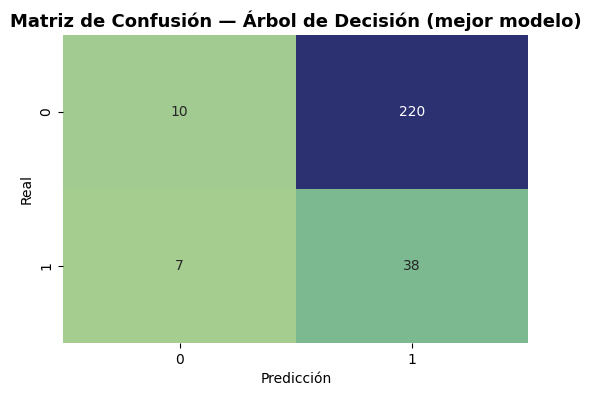

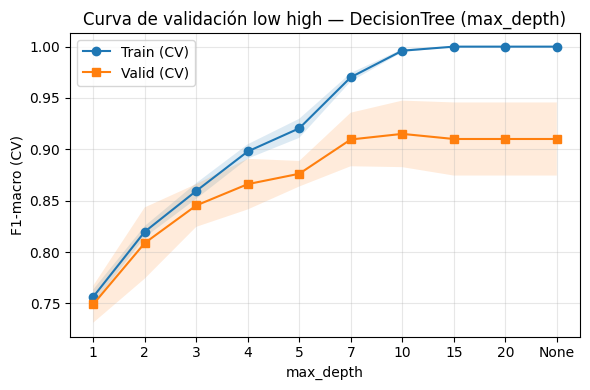

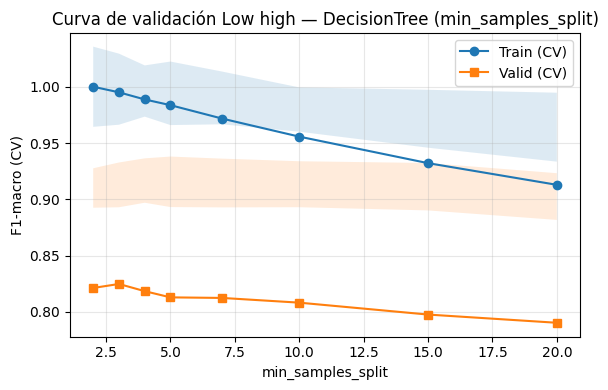

In [58]:
#parametros gridsearhCV
param_tree = {
    'max_depth': [5, 7,10, 13, 15, None],
    'min_samples_split': [2, 3, 5]
}

grid_tree_LH = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_tree,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
grid_tree_LH.fit(X_trainLH_clf_sm, y_trainLH_clf_sm)

print("🌳 Mejor modelo Árbol:")
print("Mejores parámetros:", grid_tree_LH.best_params_)
print("F1-macro promedio:", round(grid_tree_LH.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_tree_LH = grid_tree_LH.best_estimator_
y_pred_tree_LH = best_tree_LH.predict(X_test_clf_scaled_LH)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_LH, y_pred_tree_LH, digits=4))

# === Matriz de confusión ===
cm = confusion_matrix(y_test_clf_LH, y_pred_tree_LH)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Árbol de Decisión (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


#--------------------------------------------------
# ===  Convergencia según max_depth ===
#--------------------------------------------------

depths_LH = [1, 2, 3, 4, 5, 7, 10, 15, 20, None]

train_scores_LH, val_scores_LH = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           min_samples_split=grid_tree.best_params_.get('min_samples_split', 2)),
    X_trainLH_clf_sm, y_trainLH_clf_sm,
    param_name="max_depth",
    param_range=depths,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_LH = train_scores_LH.mean(axis=1)
val_mean_LH   = val_scores_LH.mean(axis=1)
train_std_LH  = train_scores_LH.std(axis=1)
val_std_LH    = val_scores_LH.std(axis=1)

x_idx = np.arange(len(depths_LH))
plt.figure(figsize=(6,4))
plt.plot(x_idx, train_mean_LH, marker='o', label="Train (CV)")
plt.plot(x_idx, val_mean_LH, marker='s', label="Valid (CV)")
plt.fill_between(x_idx, train_mean_LH-train_std_LH, train_mean_LH+train_std_LH, alpha=0.15)
plt.fill_between(x_idx, val_mean_LH-val_std_LH,   val_mean_LH+val_std_LH,   alpha=0.15)
plt.xticks(x_idx, [str(d) for d in depths])
plt.xlabel("max_depth"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación low high — DecisionTree (max_depth)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

#--------------------------------------------------
# ===  Convergencia según min_samples_split ===
#--------------------------------------------------
minsplit_list = [2, 3, 4, 5, 7, 10, 15, 20]

train_scores_LH, val_scores_LH = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           max_depth=grid_tree.best_params_.get('max_depth', None)),
    X_trainLH_clf_sm, y_trainLH_clf_sm,
    param_name="min_samples_split",
    param_range=minsplit_list,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_LH = train_scores_LH.mean(axis=1)
val_mean_LH   = val_scores_LH.mean(axis=1)
train_std_LH  = val_scores_LH.std(axis=1)
val_std_LH    = val_scores_s.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(minsplit_list, train_mean_s, marker='o', label="Train (CV)")
plt.plot(minsplit_list, val_mean_s,   marker='s', label="Valid (CV)")
plt.fill_between(minsplit_list, train_mean_LH-train_std_LH, train_mean_LH+train_std_LH, alpha=0.15)
plt.fill_between(minsplit_list, val_mean_LH-val_std_LH,     val_mean_LH+val_std_LH, alpha=0.15)
plt.xlabel("min_samples_split"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación Low high — DecisionTree (min_samples_split)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

### Random Forest

🌲 Mejor modelo Random Forest Low-High:
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
F1-macro promedio: 0.9614

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        high     0.9286    0.0565    0.1066       230
         low     0.1686    0.9778    0.2876        45

    accuracy                         0.2073       275
   macro avg     0.5486    0.5171    0.1971       275
weighted avg     0.8042    0.2073    0.1362       275



c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


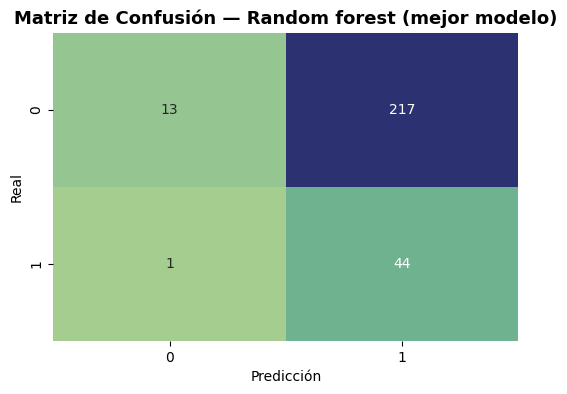

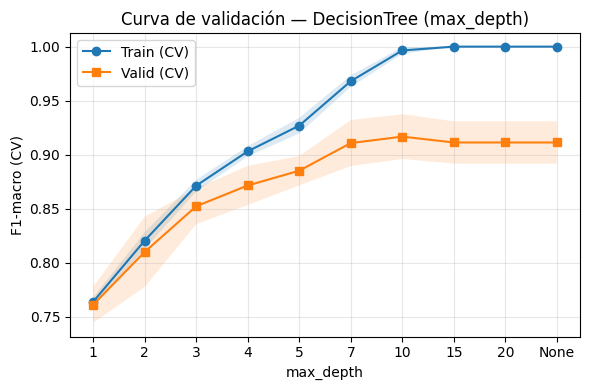

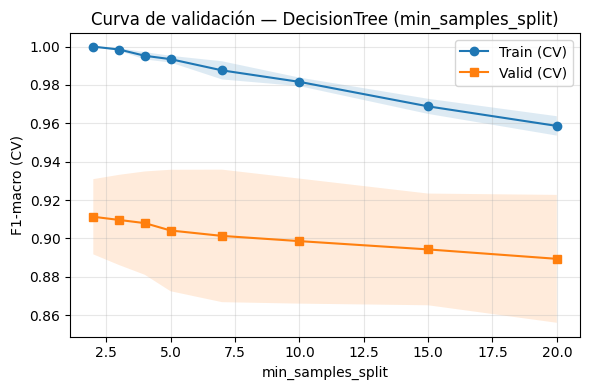

In [64]:
param_rf_LH = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf_LH = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_rf_LH,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_rf_LH.fit(X_trainLH_clf_sm, y_trainLH_clf_sm)

print("🌲 Mejor modelo Random Forest Low-High:")
print("Mejores parámetros:", grid_rf_LH.best_params_)
print("F1-macro promedio:", round(grid_rf_LH.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_randfor_LH = grid_rf_LH.best_estimator_
y_pred_randfor_LH = best_randfor_LH.predict( X_test_clf_scaled_LH)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_LH, y_pred_randfor_LH, digits=4))

# ===  Matriz de confusión ===
cm = confusion_matrix(y_test_clf_LH, y_pred_randfor_LH)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Random forest (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#--------------------------------------------------
# ===  Convergencia según max_depth ===
#--------------------------------------------------

depths_LH = [1, 2, 3, 4, 5, 7, 10, 15, 20, None]

train_scores_LH, val_scores_LH = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           min_samples_split=grid_tree.best_params_.get('min_samples_split', 2)),
    X_trainLH_clf_sm, y_trainLH_clf_sm,
    param_name="max_depth",
    param_range=depths,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_LH = train_scores_LH.mean(axis=1)
val_mean_LH   = val_scores_LH.mean(axis=1)
train_std_LH  = train_scores_LH.std(axis=1)
val_std_LH    = val_scores_LH.std(axis=1)

x_idx = np.arange(len(depths))
plt.figure(figsize=(6,4))
plt.plot(x_idx, train_mean_LH, marker='o', label="Train (CV)")
plt.plot(x_idx, val_mean_LH, marker='s', label="Valid (CV)")
plt.fill_between(x_idx, train_mean_LH-train_std_LH, train_mean_LH+train_std_LH, alpha=0.15)
plt.fill_between(x_idx, val_mean_LH-val_std_LH,   val_mean_LH+val_std_LH,   alpha=0.15)
plt.xticks(x_idx, [str(d) for d in depths])
plt.xlabel("max_depth"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación — DecisionTree (max_depth)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

#--------------------------------------------------
# ===  Convergencia según min_samples_split ===
#--------------------------------------------------
minsplit_list_LH = [2, 3, 4, 5, 7, 10, 15, 20]

train_scores_LH, val_scores_LH = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           max_depth=grid_tree.best_params_.get('max_depth', None)),
    X_trainLH_clf_sm, y_trainLH_clf_sm,
    param_name="min_samples_split",
    param_range=minsplit_list_LH,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_LH = train_scores_LH.mean(axis=1)
val_mean_LH   = val_scores_LH.mean(axis=1)
train_std_LH  = train_scores_LH.std(axis=1)
val_std_LH    = val_scores_LH.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(minsplit_list_LH, train_mean_LH, marker='o', label="Train (CV)")
plt.plot(minsplit_list_LH, val_mean_LH,   marker='s', label="Valid (CV)")
plt.fill_between(minsplit_list_LH, train_mean_LH-train_std_LH, train_mean_LH+train_std_LH, alpha=0.15)
plt.fill_between(minsplit_list_LH, val_mean_LH-val_std_LH, val_mean_LH+val_std_LH, alpha=0.15)
plt.xlabel("min_samples_split"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación — DecisionTree (min_samples_split)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()


### KNN

🤝 Mejor modelo KNN:
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
F1-macro promedio: 0.94

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        high     0.0000    0.0000    0.0000       230
         low     0.1636    1.0000    0.2812        45

    accuracy                         0.1636       275
   macro avg     0.0818    0.5000    0.1406       275
weighted avg     0.0268    0.1636    0.0460       275



c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklear

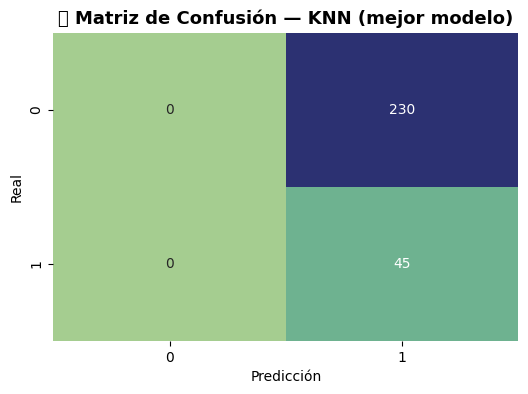

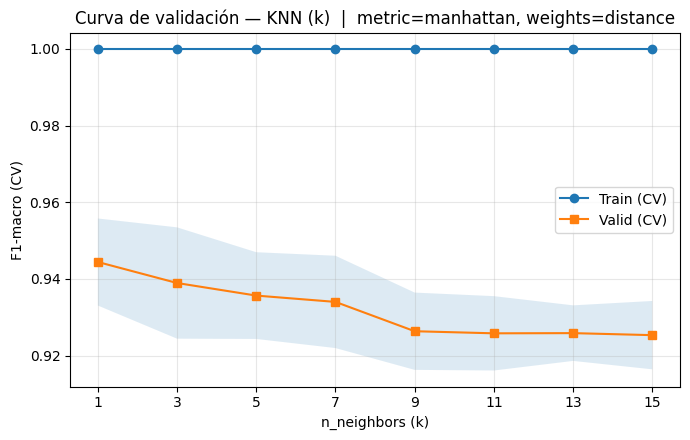

In [75]:
param_knn_LH = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],   # uniform = mismo peso, distance = peso por distancia
    'metric': ['euclidean', 'manhattan']  # diferentes tipos de distancia
}

grid_knn_LH = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_knn_LH,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_knn_LH.fit(X_trainLH_clf_sm, y_trainLH_clf_sm)

print("🤝 Mejor modelo KNN:")
print("Mejores parámetros:", grid_knn_LH.best_params_)
print("F1-macro promedio:", round(grid_knn_LH.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_knn_LH = grid_knn_LH.best_estimator_
y_pred_knn_LH = best_knn_LH.predict(X_test_clf_scaled_LH)

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_LH, y_pred_knn_LH, digits=4))

# === Matriz de confusión ===
KNN_cm_LH = confusion_matrix(y_test_clf_LH, y_pred_knn_LH)
plt.figure(figsize=(6,4))
sns.heatmap(KNN_cm_LH, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("🤝 Matriz de Confusión — KNN (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==============================
# 1) Curva de validación vs k
# ==============================
k_list = np.array([1,3,5,7,9,11,13,15])

best_metric  = grid_knn_LH.best_params_.get('metric', 'euclidean')
best_weights = grid_knn_LH.best_params_.get('weights', 'uniform')

knn_fixed = KNeighborsClassifier(metric=best_metric, weights=best_weights)

train_scores, val_scores = validation_curve(
    estimator=knn_fixed,
    X=X_trainLH_clf_sm, y=y_trainLH_clf_sm,
    param_name="n_neighbors",
    param_range=k_list,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1); train_std = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1);   val_std   = val_scores.std(axis=1)

plt.figure(figsize=(7,4.5))
plt.plot(k_list, train_mean, marker='o', label="Train (CV)")
plt.plot(k_list, val_mean,   marker='s', label="Valid (CV)")
plt.fill_between(k_list, val_mean-val_std, val_mean+val_std, alpha=.15)
plt.xticks(k_list); plt.xlabel("n_neighbors (k)"); plt.ylabel("F1-macro (CV)")
plt.title(f"Curva de validación — KNN (k)  |  metric={best_metric}, weights={best_weights}")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()




### cross validation clasificacion LOW - High

In [77]:
cv_LH = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models_clf_LH = {
    "Árbol": DecisionTreeClassifier(max_depth=None, min_samples_split=2, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
}

# ========================================================
# Función de resumen
# ========================================================
def resumen(scores):
    mean = scores.mean()
    std  = scores.std(ddof=1)
    n    = len(scores)
    ci_lo = mean - 1.96 * std / np.sqrt(n)
    ci_hi = mean + 1.96 * std / np.sqrt(n)
    return mean, std, ci_lo, ci_hi

# ========================================================
# Ejecución y salida combinada
# ========================================================
for nombreLH, modeloLH in models_clf_LH.items():
    print(f"\n🔹 {nombreLH} — F1-Weighted y F1-Macro")
    
    f1_weighted_LH = cross_val_score(modeloLH,X_trainLH_clf_sm, y_trainLH_clf_sm,
                                  cv=cv_LH, scoring='f1_weighted')
    f1_macro_LH = cross_val_score(modeloLH, X_trainLH_clf_sm, y_trainLH_clf_sm,
                               cv=cv_LH, scoring='f1_macro')
    
    for i, (fw, fm) in enumerate(zip(f1_weighted_LH, f1_macro_LH), 1):
        print(f"   Fold {i}: F1-weighted = {fw:.4f} | F1-macro = {fm:.4f}")
    
    # Resúmenes
    m_w, sd_w, lo_w, hi_w = resumen(f1_weighted_LH)
    m_m, sd_m, lo_m, hi_m = resumen(f1_macro_LH)
    
    print(f"\n   📊 Resumen K-Fold (K={cv_LH.get_n_splits()}):")
    print(f"   • Promedio F1-weighted: {m_w:.4f} ± {sd_w:.4f} (IC95% [{lo_w:.4f}, {hi_w:.4f}])")
    print(f"   • Promedio F1-macro:    {m_m:.4f} ± {sd_m:.4f} (IC95% [{lo_m:.4f}, {hi_m:.4f}])")


🔹 Árbol — F1-Weighted y F1-Macro
   Fold 1: F1-weighted = 0.9021 | F1-macro = 0.9021
   Fold 2: F1-weighted = 0.9022 | F1-macro = 0.9022
   Fold 3: F1-weighted = 0.9076 | F1-macro = 0.9076
   Fold 4: F1-weighted = 0.9565 | F1-macro = 0.9565
   Fold 5: F1-weighted = 0.9402 | F1-macro = 0.9402
   Fold 6: F1-weighted = 0.8912 | F1-macro = 0.8912
   Fold 7: F1-weighted = 0.9402 | F1-macro = 0.9402
   Fold 8: F1-weighted = 0.9456 | F1-macro = 0.9456
   Fold 9: F1-weighted = 0.8798 | F1-macro = 0.8798
   Fold 10: F1-weighted = 0.9290 | F1-macro = 0.9290

   📊 Resumen K-Fold (K=10):
   • Promedio F1-weighted: 0.9194 ± 0.0261 (IC95% [0.9033, 0.9356])
   • Promedio F1-macro:    0.9194 ± 0.0261 (IC95% [0.9033, 0.9356])

🔹 Random Forest — F1-Weighted y F1-Macro
   Fold 1: F1-weighted = 0.9456 | F1-macro = 0.9456
   Fold 2: F1-weighted = 0.9728 | F1-macro = 0.9728
   Fold 3: F1-weighted = 0.9565 | F1-macro = 0.9565
   Fold 4: F1-weighted = 0.9837 | F1-macro = 0.9837
   Fold 5: F1-weighted = 0.962

# Ensamble

In [90]:
joblib.dump(best_randfor_LH, "../modelos/best_randForest_LH.joblib")
joblib.dump(best_randfor, "../modelos/best_randForest_Medium.joblib")
print("✅ Modelo Random Forest (Low-High) guardado correctamente.")

✅ Modelo Random Forest (Low-High) guardado correctamente.


In [101]:
# --- util: forzar etiquetas a texto coherentes ---
def to_df_like_model(X, model):
    if isinstance(X, np.ndarray) and hasattr(model, "feature_names_in_"):
        return pd.DataFrame(X, columns=model.feature_names_in_)
    return X

def to_text_labels(y):
    y = pd.Series(y)
    if np.issubdtype(y.dtype, np.number):
        return y.replace({0:'high', 1:'medium', 2:'low'}).values
    return y.astype(str).values

def predict_hierarchical(X, stage1, stage2, thr_medium=0.50):
    # asegurar DataFrame con nombres
    X = to_df_like_model(X, stage1)

    classes1 = list(stage1.classes_)
    idx_medium = classes1.index('medium')
    p_medium = stage1.predict_proba(X)[:, idx_medium]
    is_medium = p_medium >= thr_medium

    y_pred = np.empty(X.shape[0], dtype=object)
    y_pred[is_medium] = 'medium'

    idx_nm = ~is_medium
    if idx_nm.any():
        X_nm = X.loc[idx_nm] if hasattr(X, "loc") else X[idx_nm]
        # asegurar nombres también para stage2
        X_nm = to_df_like_model(X_nm, stage2)
        y_pred[idx_nm] = stage2.predict(X_nm)
    return y_pred

def tune_threshold_medium(X_valid, y_valid, stage1, stage2, grid=np.linspace(0.30,0.70,21)):
    X_valid = to_df_like_model(X_valid, stage1)
    y_true_txt = to_text_labels(y_valid)
    best_thr, best_f1 = 0.5, -1.0
    for t in grid:
        y_hat = predict_hierarchical(X_valid, stage1, stage2, thr_medium=t)
        f1m = f1_score(y_true_txt, y_hat, average='macro', labels=['low','medium','high'])
        if f1m > best_f1:
            best_f1, best_thr = f1m, t
    return best_thr, best_f1


stage1 classes_: ['medium' 'no_medium']
stage2 classes_: ['high' 'low']
Mejor umbral medium: 0.42 F1-macro: 0.4351
              precision    recall  f1-score   support

         low     0.1463    0.8372    0.2491        43
      medium     0.9726    0.9911    0.9818       896
        high     0.8182    0.0390    0.0744       231

    accuracy                         0.7974      1170
   macro avg     0.6457    0.6224    0.4351      1170
weighted avg     0.9118    0.7974    0.7757      1170



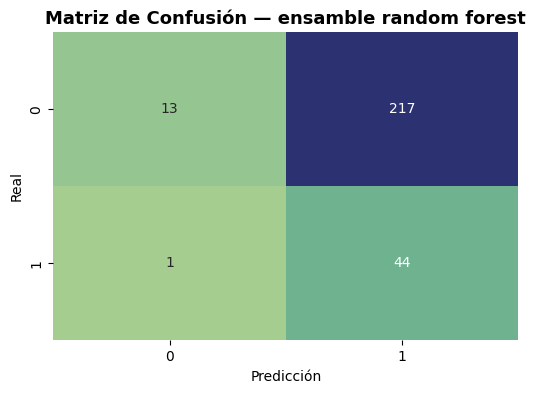

In [102]:
# Cargar en el orden CORRECTO
stage1_clf = joblib.load("../modelos/best_randForest_Medium.joblib")  # medium vs no_medium
stage2_clf = joblib.load("../modelos/best_randForest_LH.joblib")      # low vs high

print("stage1 classes_:", stage1_clf.classes_)  # ['medium','no_medium'] esperado
print("stage2 classes_:", stage2_clf.classes_)  # ['high','low'] esperado

# y_test_clf = (numérico 0/1/2) ; X_test_clf_scaled = test general
y_test_txt = to_text_labels(y_test_clf)  # <-- convierte a 'high','medium','low'

best_thr, best_f1 = tune_threshold_medium(X_test_clf_scaled, y_test_txt, stage1_clf, stage2_clf)
y_pred_final = predict_hierarchical(X_test_clf_scaled, stage1_clf, stage2_clf, thr_medium=best_thr)

print("Mejor umbral medium:", round(best_thr,3), "F1-macro:", round(best_f1,4))
print(classification_report(y_test_txt, y_pred_final, digits=4, labels=['low','medium','high']))

matriz_confusion = confusion_matrix(y_test_txt, y_pred_final)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — ensamble random forest", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
